# Описание задания:
1. Проанализировать данные
2. Обучить нейронную сеть с ипользование фреймворка на выбор
3. Снять метрики качества
4. Результат выполненного тестового задания: ссылка на открытый репозиторий в Git

In [1]:
import os
from collections import Counter

import numpy as np
import seaborn as sns
from PIL import Image
from scipy import stats as st
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

## ==============================EDA=================================

Прежде всего сделаем первичный анализ данных, посмотрим какие изображения есть, если ли особенные, а самое главное попробуем понять как с данными. Для удобства сразу положим пути для train и test в списки.

Что сразу следует проверить:
- Глазами посмотреть данные
- Дупликаты (однако в описании датасета уже написано, что их нет)
- Размеры изображений (правда ли что все изображения одного формата, например, вдруг там есть и цветные и серые)
- В какой размер лучше всего кропать картинки

In [2]:
path = '/kaggle/input/cats-and-dogs-image-classification'
train_folder_path = '/kaggle/input/cats-and-dogs-image-classification/train'
cats_path = os.path.join(path, train_folder_path, 'cats') # 0
dogs_path = os.path.join(path, train_folder_path, 'dogs') # 1

train_cats = [os.path.join(cats_path, pth) for pth in os.listdir(cats_path)]
train_dogs = [os.path.join(dogs_path, pth) for pth in os.listdir(dogs_path)]
train_images =  train_cats + train_dogs

test_folder_path = '/kaggle/input/cats-and-dogs-image-classification/test'
cats_path = os.path.join(path, test_folder_path, 'cats') # 0
dogs_path = os.path.join(path, test_folder_path, 'dogs') # 1

test_cats = [os.path.join(cats_path, pth) for pth in os.listdir(cats_path)]
test_dogs = [os.path.join(dogs_path, pth) for pth in os.listdir(dogs_path)]
test_images = test_cats + test_dogs

print(f'train:\tcats={len(train_cats)},dogs={len(train_dogs)}')
print(f'test:\tcats={len(test_cats)}, dogs={len(test_dogs)}')
print(f'train:\tall={len(train_images)}')
print(f'test:\tall={len(test_images)}')

train:	cats=279,dogs=278
test:	cats=70, dogs=70
train:	all=557
test:	all=140


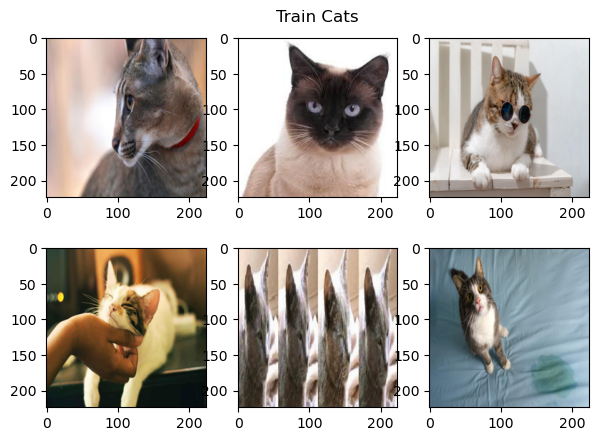

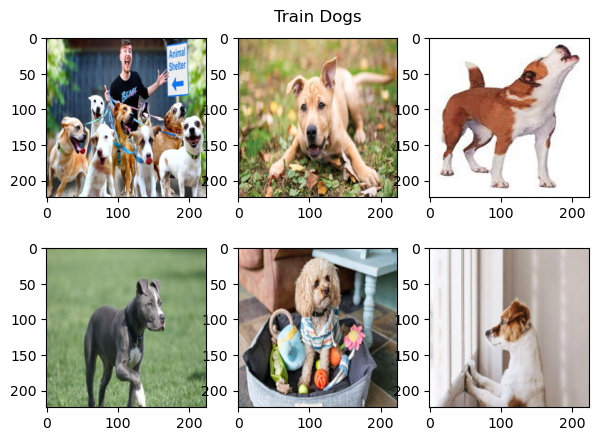

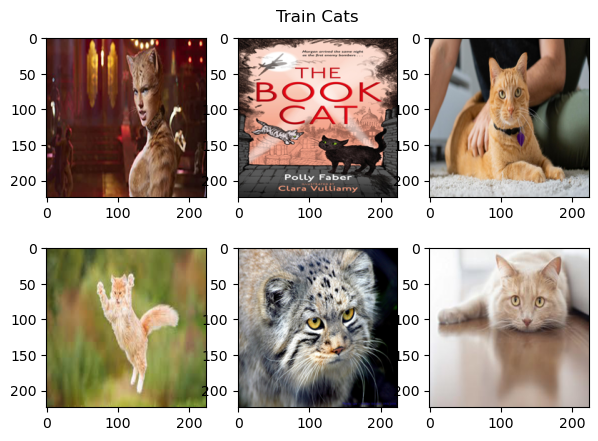

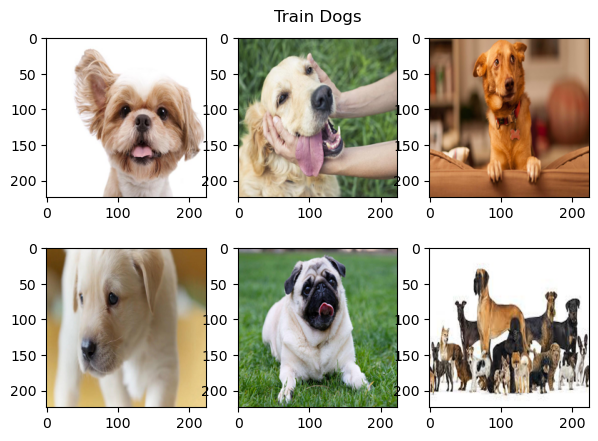

In [3]:
def plot_examples(images):
    fig = plt.figure(figsize=(7, 5))
    plt.title('Train Cats')
    plt.axis('off')
    rows, columns = 2, 3
    for i, img in enumerate(images[:6]):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(Image.open(img).resize((224, 224)))

    fig = plt.figure(figsize=(7, 5))
    plt.title('Train Dogs')
    plt.axis('off')
    rows, columns = 2, 3
    for i, img in enumerate(images[-6:]):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(Image.open(img).resize((224, 224)))

plot_examples(train_images)
plot_examples(test_images)

#### После того как взглянули на данные, проверим сколько  каналов в картинках:

In [4]:
def check_channels(images):
    channels = []
    for img in images:
        channels.append(Image.open(img).mode)
    return Counter(channels)

print(f'train img channels: {check_channels(train_images)}')
print(f'test img channels: {check_channels(test_images)}')

train img channels: Counter({'RGB': 556, 'L': 1})
test img channels: Counter({'RGB': 140})


Видно что все картинки цветные(RGB), кроме одной, которая находится в трейне, она серая, можно просто выкинуть ее или же конкатанировать ее 3 раза, чтобы получилось 3х канальное изображение, попробуем это сделать и посмотрим, что выйдет:

shape: (426, 640, 3)


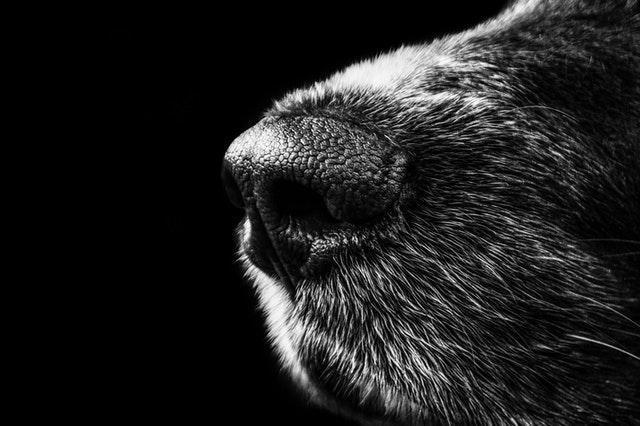

In [5]:
for img in train_images:
    im = Image.open(img) 
    if im.mode == 'L':
        break
        
rgbimg = Image.new("RGB", im.size)
rgbimg.paste(im)
print(f'shape: {np.array(rgbimg).shape}')
rgbimg

Предлагаю посмотреть какую площадь занимает каждая картинка. Ведь чтобы работать с ними дальше, надо подумать во что кропнуть картинку, чтобы при этом сохранить максимум информации. Обычно выбирают ресайз 128x128, 224x224, 384x384, 512x512. Но все зависит от задачи. После того как посчитаем площади и построим их распределение, найдем моду, т.е будем знать какая плозадь изображения встречается наиболее часто, после чего возьмем корень и будет уже ориентировочно знать размер в который будет делать ресайз.

In [6]:
def find_sq(images):
    sq = []
    for img in images:
        sq.append(np.product(Image.open(img).size))
    return sq

sq_train = find_sq(train_images)
sq_test = find_sq(test_images)

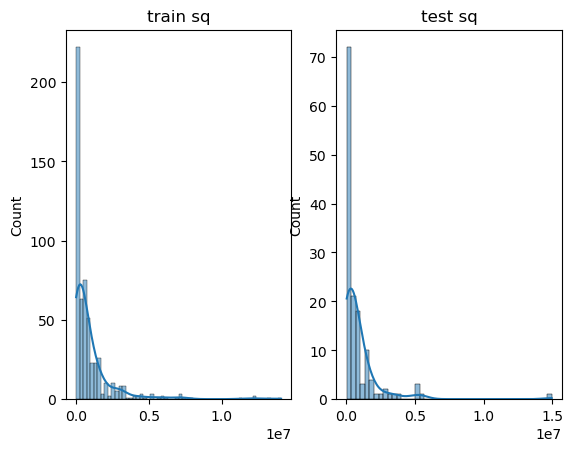

In [7]:
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('train sq')
ax[1].title.set_text('test sq')
sns.histplot(sq_train, kde=True, ax=ax[0])
sns.histplot(sq_test, kde=True, ax=ax[1])
fig.show()

In [8]:
print('candidate shape: \n', np.sqrt(st.mode(sq_test)))
print('candidate shape: \n', np.sqrt(st.mode(sq_train)))

candidate shape: 
 [[224.33234274]
 [  2.82842712]]
candidate shape: 
 [[224.33234274]
 [  6.        ]]


Супер, теперь мы узнали, что скорее всего можно и нужно переводить картинку в размер 224x224, после чего можно начинать строить модель.

## =========================Build Model=============================

Сделаем конфиг в котором будем хранить важную информацию. Кроме того создадим датасеты, где **котики это 0, а собачки это 1**.

In [9]:
class config:
    img_size = 224
    batch_size = 32
    path = '/kaggle/input/cats-and-dogs-image-classification'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using {} device'.format(config.device))

Using cuda device


In [10]:
class CatDogDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        cats_path = os.path.join(config.path, folder_path, 'cats') # 0
        dogs_path = os.path.join(config.path, folder_path, 'dogs') # 1
        
        self.images = [(os.path.join(cats_path, pth), 0.) for pth in os.listdir(cats_path)] + \
                        [(os.path.join(dogs_path, pth), 1.) for pth in os.listdir(dogs_path)]
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        pth, label = self.images[idx] 
        image = transforms.ToTensor()(Image.open(pth))
        
        if image.shape[0] == 1:
            image = torch.concat((image, image, image))
            
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

transform_train = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])    

transform_test = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])    


datasets = {}
datasets['train'] = CatDogDataset(os.path.join(config.path, 'train'), transform=transform_train)
datasets['test'] = CatDogDataset(os.path.join(config.path, 'test'), transform=transform_test)
    
dataloaders = {}
dataloaders['train'] =  DataLoader(
        dataset=datasets['train'],
        shuffle=True,
        batch_size=config.batch_size,
        pin_memory=True,
        num_workers=2
    )
dataloaders['test'] =  DataLoader(
        dataset=datasets['test'],
        shuffle=True,
        batch_size=config.batch_size,
        pin_memory=True,
        num_workers=2
    )


In [11]:
def train_loop(model, dataloader, loss_fn, optimizer, scheduler=None, history_loss=None, history_acc=None):
    epoch_loss = 0
    epoch_acc = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(config.device), y.to(config.device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        acc = ((pred.argmax(dim=1)==y).float().mean())
        epoch_acc += acc/len(dataloader)
        epoch_loss += loss/len(dataloader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if scheduler:
        scheduler.step()
        
    print(f'train_loss: {epoch_loss}, train_acc: {epoch_acc}')
    
    if history_loss is not None:
        history_loss.append(float(epoch_loss))
    if history_acc is not None:
        history_acc.append(float(epoch_acc))

def test_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):
    epoch_acc = 0
    epoch_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
            X, y = X.to(config.device), y.to(config.device)
            pred = model(X)
            loss = loss_fn(pred, y)
            acc = ((pred.argmax(dim=1)==y).float().mean())
            epoch_acc += acc/len(dataloader)
            epoch_loss += loss/len(dataloader)
            
    print(f'test_loss: {epoch_loss}, test_acc: {epoch_acc}')
    
    if history_loss is not None:
        history_loss.append(float(epoch_loss))
    if history_acc is not None:
        history_acc.append(float(epoch_acc))

In [12]:
def plot_learning_process(train_loss, train_acc, val_loss, val_acc):
    fig = plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(121)
    ax1.set_title('loss by epoch')
    ax1.plot(np.arange(0, len(train_loss)), train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)), val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss function')

    ax2 = plt.subplot(122)
    ax2.set_title('accuracy by epoch')
    ax2.plot(np.arange(0, len(train_acc)), train_acc, label='train')
    ax2.plot(np.arange(0, len(val_acc)), val_acc, label='val')
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    
    fig.tight_layout()
    plt.show()

### =============================Соберем модель и обучим ее==========================
Обучать модель с нуля кажется не самой лучшей идеей, так как данных достаточно мало, конечно мы бы могли сделать аугментации, но проще и выгоднее дообучить модель, тем более, что очень много моделей преобучены на картинки размером 224х224. Среди моделей попробовал такие модели как: **resnet18, resnet_34, inception_resnet_v2, mobilevitv2_100 - mobilevitv2_150, xception**. И остановился на последней. Но вот вопрос, как будем обучать? Можно попробовать **fine tuning** на всей модели, но так как датасет мал, предобученная модель может разучится тем примитивам, которые изучала раньше. Поэтому сделаем **transfer learning**, т.е заморозим слои исходной модели и добавим ей новый **head**, который будет обучаться.

In [13]:
import timm
base_model = timm.create_model(model_name="xception", pretrained=True)
for param in base_model.parameters():
    param.requaer_grad = False
    
model = nn.Sequential(
    base_model,
    nn.ReLU(),
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
).to(config.device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [14]:
epochs = 15
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = None #torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: 0.75 ** x)

train_loss, test_loss = [], []
train_acc, test_acc = [], []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(model, dataloaders['train'], loss_fn, optimizer, scheduler, history_loss=train_loss, history_acc=train_acc)
    test_loop(model, dataloaders['test'], loss_fn, history_loss=test_loss, history_acc=test_acc)

Epoch 1
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.6763545870780945, train_acc: 0.6686699986457825


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.6678237915039062, test_acc: 0.6875
Epoch 2
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.6386691927909851, train_acc: 0.84642094373703


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.6335620880126953, test_acc: 0.8333333730697632
Epoch 3
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.5853608846664429, train_acc: 0.9332265257835388


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.5862777829170227, test_acc: 0.8645833730697632
Epoch 4
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.5087221264839172, train_acc: 0.9496527314186096


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.5065218210220337, test_acc: 0.90625
Epoch 5
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.4166368246078491, train_acc: 0.9583332538604736


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.4336337149143219, test_acc: 0.8958333730697632
Epoch 6
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.3233495056629181, train_acc: 0.9714208841323853


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.33568325638771057, test_acc: 0.9437500238418579
Epoch 7
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.2387489229440689, train_acc: 0.9791667461395264


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.31849879026412964, test_acc: 0.8770833611488342
Epoch 8
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.17270605266094208, train_acc: 0.9895833134651184


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.2273370921611786, test_acc: 0.949999988079071
Epoch 9
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.12857745587825775, train_acc: 0.9843750596046448


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.1980355978012085, test_acc: 0.9583333730697632
Epoch 10
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.10495908558368683, train_acc: 0.9775640964508057


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.19370852410793304, test_acc: 0.9395833611488342
Epoch 11
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.07016178965568542, train_acc: 0.996527910232544


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.17123636603355408, test_acc: 0.9333333373069763
Epoch 12
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.055642131716012955, train_acc: 0.9947918653488159


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.16385917365550995, test_acc: 0.9270833730697632
Epoch 13
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.037060536444187164, train_acc: 1.000000238418579


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.1578294038772583, test_acc: 0.9395833611488342
Epoch 14
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.04165958613157272, train_acc: 0.99051833152771


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.1467178761959076, test_acc: 0.949999988079071
Epoch 15
-------------------------------


Batch #:   0%|          | 0/18 [00:00<?, ?it/s]

train_loss: 0.03008408285677433, train_acc: 0.9982640743255615


Batch #:   0%|          | 0/5 [00:00<?, ?it/s]

test_loss: 0.13907144963741302, test_acc: 0.949999988079071


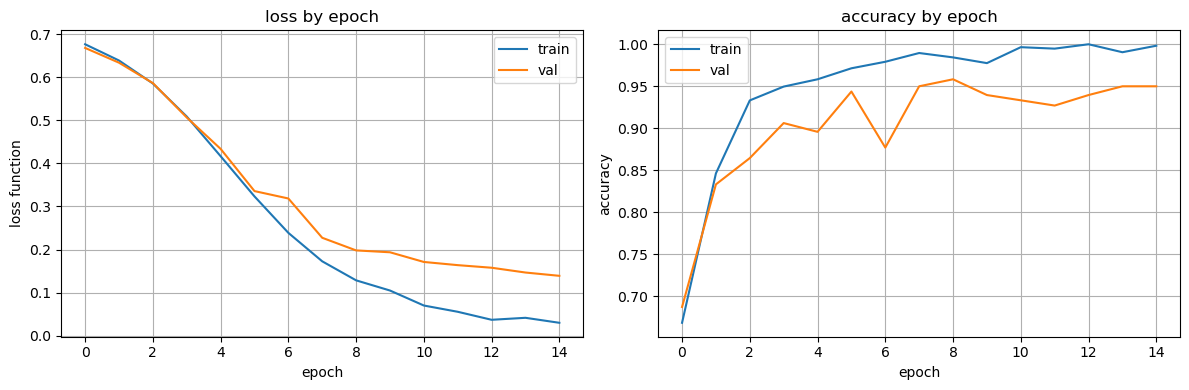

In [15]:
plot_learning_process(train_loss, train_acc, test_loss, test_acc)

Кривые обучения выглядят хорошо, нет явного переобучения. Взглянем на метрики.

In [16]:
def get_predicts(model, dataloader):
    preds = np.array([]).reshape(0, 2)
    truth = np.array([])
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(config.device), y
            pred = np.array(model(X).cpu())
            preds = np.vstack([preds, pred])
            truth = np.append(truth, y)
    return preds, truth
pred, y = get_predicts(model, dataloaders['test'])

  0%|          | 0/5 [00:00<?, ?it/s]

accuracy:	0.9357142857142857
precision:	0.9295774647887324
recall: 	0.9428571428571428
roc auc:	0.9883673469387755
f1 score:	0.9361702127659575


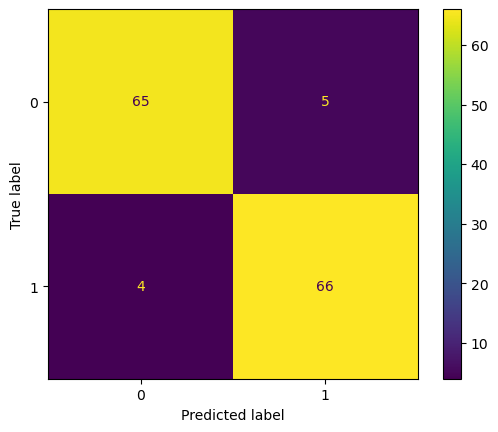

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f'accuracy:\t{accuracy_score(y, pred.argmax(1))}')
print(f'precision:\t{precision_score(y, pred.argmax(1))}')
print(f'recall: \t{recall_score(y, pred.argmax(1))}')
print(f'roc auc:\t{roc_auc_score(y, pred[:, 1])}')
print(f'f1 score:\t{f1_score(y, pred.argmax(1))}')

ConfusionMatrixDisplay(confusion_matrix(y, pred.argmax(1))).plot();

Метрики достаточно хорошие

### ======================Посмотрим на реальные примеры из интернета================

In [18]:
import requests

def pred_img(model, image):
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image)
    image = image[None, :].to(config.device)
    pred = model(image)
    prob = F.softmax(pred[0], dim=-1).tolist()
    
    return ('Cat', prob) if pred.argmax() == 0 else ('Dog', prob)

('Dog', [0.3559924364089966, 0.6440075635910034])


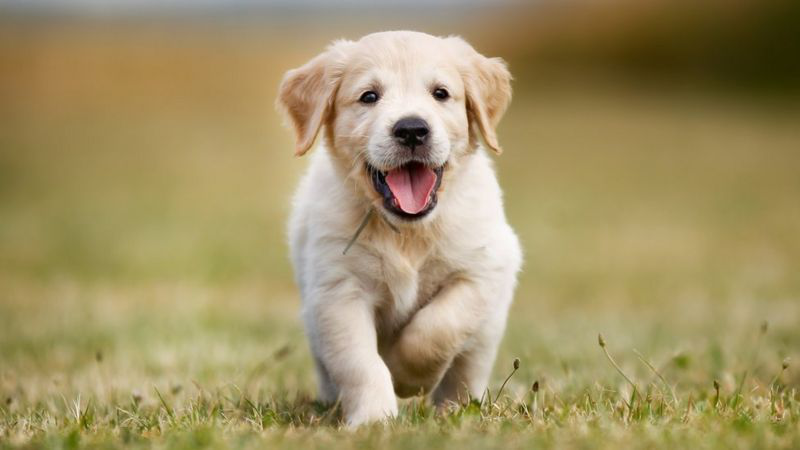

In [19]:
url = 'https://ichef.bbci.co.uk/news/800/cpsprodpb/475B/production/_98776281_gettyimages-521697453.jpg'
image = Image.open(requests.get(url, stream=True).raw)
print(pred_img(model, image))
image

('Cat', [0.7752534747123718, 0.22474652528762817])


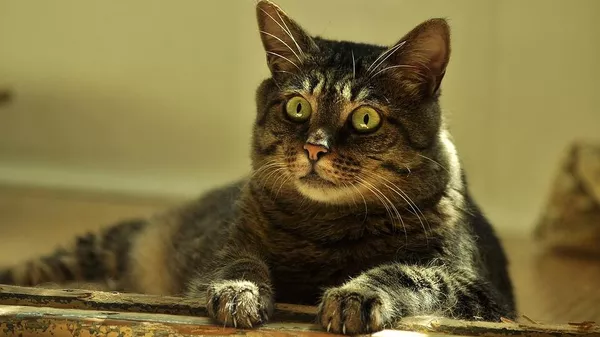

In [20]:
url = 'https://cdnn1.img.crimea.ria.ru/img/07e5/0b/15/1121496728_0:85:960:625_600x0_80_0_0_4437211d88b46183a1faa4c08a81349f.jpg.webp'
image = Image.open(requests.get(url, stream=True).raw)
print(pred_img(model, image))
image

Модель хорошо справляется с картинками, который точно уж никак не могли попасть в данные, снятие метрик показало хороший результат.